
Option Pricing Analysis - AAPL
Strike Price: 180.00 $
Current Stock Price: 234.65 $
Days to Maturity: 197

Pricing Results:
Method                    Price
------------------------------
Market          $    64.75

Analysis: Option appears OVERVALUED in the market
Monte Carlo              56.86 $
Black-Scholes            60.14 $


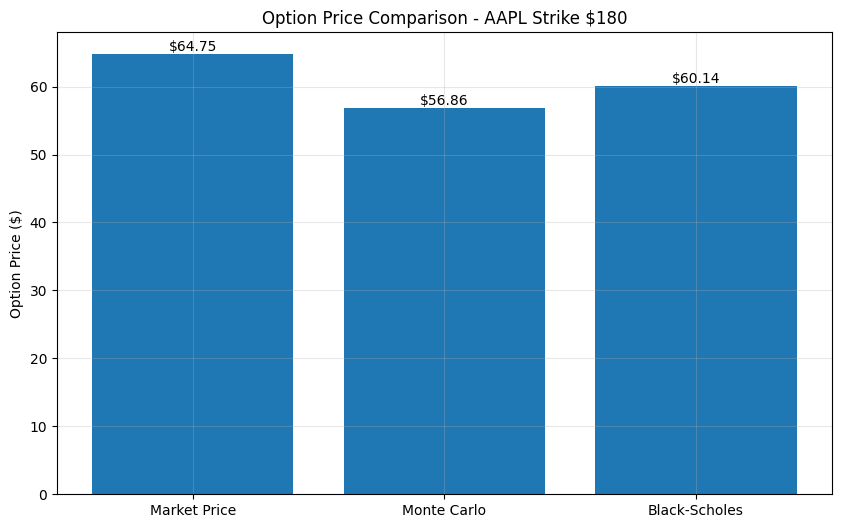

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class OptionPricer:
    def __init__(self, ticker="AAPL", strike_price=180, maturity_date=None, 
                 risk_free_rate=0.05, num_simulations=10000):
        self.ticker = ticker
        self.strike_price = strike_price
        self.stock = yf.Ticker(ticker)
        
        try:
            expirations = self.stock.options
            if maturity_date is None:
                target_date = datetime.now() + timedelta(days=180)
            else:
                target_date = datetime.strptime(maturity_date, "%Y-%m-%d")
            closest_date = min(expirations, 
                             key=lambda x: abs(datetime.strptime(x, "%Y-%m-%d") - target_date))
            self.maturity_date = closest_date
        except Exception:
            self.maturity_date = (datetime.now() + timedelta(days=180)).strftime("%Y-%m-%d")
        
        self.risk_free_rate = risk_free_rate
        self.num_simulations = num_simulations
        self.current_price = self.stock.history(period="1d")['Close'].iloc[-1]
        
        maturity_datetime = datetime.strptime(self.maturity_date, "%Y-%m-%d")
        current_datetime = datetime.now()
        if maturity_datetime <= current_datetime:
            raise ValueError(f"Maturity date {self.maturity_date} must be in the future")
        
        self.time_to_maturity = (maturity_datetime - current_datetime).days / 365.0
        historical_data = self.stock.history(period="1y")
        self.volatility = np.sqrt(252) * historical_data['Close'].pct_change().std()

    def generate_random_walks(self):
        dt = self.time_to_maturity / 252
        num_steps = max(1, int(self.time_to_maturity * 252))
        Z = np.random.standard_normal((self.num_simulations, num_steps))
        paths = np.zeros((self.num_simulations, num_steps + 1))
        paths[:, 0] = self.current_price
        
        for t in range(1, num_steps + 1):
            paths[:, t] = paths[:, t-1] * np.exp((self.risk_free_rate - 0.5 * self.volatility**2) * dt + 
                                                self.volatility * np.sqrt(dt) * Z[:, t-1])
        return paths

    def monte_carlo_price(self):
        paths = self.generate_random_walks()
        final_prices = paths[:, -1]
        payoffs = np.maximum(final_prices - self.strike_price, 0)
        return np.exp(-self.risk_free_rate * self.time_to_maturity) * np.mean(payoffs)

    def black_scholes_price(self):
        d1 = (np.log(self.current_price / self.strike_price) + 
              (self.risk_free_rate + 0.5 * self.volatility**2) * self.time_to_maturity) / \
             (self.volatility * np.sqrt(self.time_to_maturity))
        d2 = d1 - self.volatility * np.sqrt(self.time_to_maturity)
        return self.current_price * norm.cdf(d1) - \
               self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(d2)

    def get_market_price(self):
        options = self.stock.option_chain(self.maturity_date)
        calls = options.calls
        closest_strike_idx = (calls['strike'] - self.strike_price).abs().idxmin()
        return calls.iloc[closest_strike_idx]['lastPrice']

    def compare_prices(self):
        mc_price = self.monte_carlo_price()
        bs_price = self.black_scholes_price()
        market_price = self.get_market_price()
        
        print(f"\nOption Pricing Analysis - {self.ticker}")
        print(f"Strike Price: {self.strike_price:.2f} $")
        print(f"Current Stock Price: {self.current_price:.2f} $")
        print(f"Days to Maturity: {self.time_to_maturity*365:.0f}")
        
        print(f"\nPricing Results:")
        print(f"{'Method':<20} {'Price':>10}")
        print("-" * 30)
        
        if market_price is not None:
            print(f"{'Market':<15} ${market_price:>9.2f}")
            avg_model_price = (mc_price + bs_price) / 2
            if market_price > avg_model_price * 1.05:
                print("\nAnalysis: Option appears OVERVALUED in the market")
            elif market_price < avg_model_price * 0.95:
                print("\nAnalysis: Option appears UNDERVALUED in the market")
            else:
                print("\nAnalysis: Option appears FAIRLY PRICED in the market")
        
        print(f"{'Monte Carlo':<20} {mc_price:>9.2f} $")
        print(f"{'Black-Scholes':<20} {bs_price:>9.2f} $")
        
        self.plot_price_comparison(mc_price, bs_price, market_price)
        return mc_price, bs_price, market_price

    def plot_price_comparison(self, mc_price, bs_price, market_price):
        if market_price is not None:
            methods = ['Market Price', 'Monte Carlo', 'Black-Scholes']
            prices = [market_price, mc_price, bs_price]
        else:
            methods = ['Monte Carlo', 'Black-Scholes']
            prices = [mc_price, bs_price]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(methods, prices)
        plt.title(f'Option Price Comparison - {self.ticker} Strike ${self.strike_price}')
        plt.ylabel('Option Price ($)')
        plt.grid(True, alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'${height:.2f}',
                    ha='center', va='bottom')
        plt.show()

if __name__ == "__main__":
    pricer = OptionPricer(
        ticker="AAPL",
        strike_price=180,
        risk_free_rate=0.05,
        num_simulations=10000
    )
    mc_price, bs_price, market_price = pricer.compare_prices()
